# Krypton Lifetime maps

### Author:  JMH, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Wed Oct 16 13:41:41 2019


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-10-16 13:41:41,717 | INFO : Hello world!


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
import subprocess

# run_number = <RUN_NUMBER>
# num_files = <NUM_FILES>
# analysis_tag = '<ANALYSIS_TAG>'
# input_tag = '<INPUT_TAG>'

# For testing
run_number  = 7517
file_range  = 0, 1 
num_files = 1
analysis_tag = 'ScriptTest'
input_tag = 'ScriptTest'

num_xy_bins = 10
regularize = False

t_start = time.time()

lifetime_limits = (1000, 15000)
e0_limits = (7000, 14000)
e0_limits_rphi = (12000, 14000)

input_path  = f"$IC_DATA/"+input_tag+"/dst"
map_path    = f"$IC_DATA/"+analysis_tag+"/maps"

input_file_name = 'dst_test.h5'
input_file_names  = [ input_file_name ]
    
time_bins = 10
output_file_name  = ' '
map_file_name     = 'kr_maps_xy_'+str(run_number)+'.h5'
map_file_name_ts  = f'kr_maps_rphi_5_8_ts_{time_bins}_'+str(run_number)+'.h5'
emap_file_name    = 'kr_emap_xy_'+str(num_xy_bins)+'_'+str(num_xy_bins)+'_r_'+str(run_number)+'_'+analysis_tag+'.h5'

### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import timeit
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [10]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [11]:
from krcal.core.stat_functions      import mean_and_std

In [12]:
from krcal.core.ranges_and_bins_functions      import kr_ranges_and_bins

In [13]:
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [14]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [15]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [16]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [17]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName

In [18]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [19]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

In [20]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [21]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [22]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [23]:
from krcal.core.selection_functions  import event_map_df
from krcal.core.selection_functions  import select_rphi_sectors_df
from krcal.core.selection_functions  import select_xy_sectors_df
from krcal.core.selection_functions  import get_time_series_df
from krcal.core.fitmap_functions     import time_fcs_df
from krcal.core.fitmap_functions     import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions     import fit_map_xy_df

In [24]:
from numpy import pi, sqrt

In [25]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [26]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [27]:
log = logging.getLogger()

### Input/output 

In [28]:
t0 = time.time()
dst           = load_dsts([input_file_name], "DST", "Events")
t1 = time.time()
print(f'Read in file time: t = {t1 -t0}')

Read in file time: t = 0.13864707946777344


In [29]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 40551


In [30]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [31]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [32]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (10000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 18000)
lt_range = (1000, 9000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = num_xy_bins,
                                                        ynbins    = num_xy_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 25,
                                                        s2qnbins  = 25,
                                                        tpsamples = 1) # tsamples in seconds

In [33]:
dstFid = dst[in_range(dst.R, 0, RMAX)]

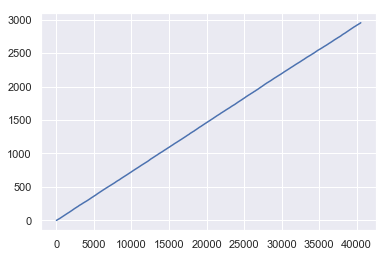

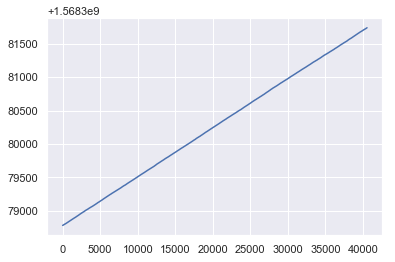

In [34]:
dst_time = dstFid.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst_time.assign(DT=DT)
plt.plot(DT)
plt.show()
plt.plot(T)
plt.show()

In [35]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

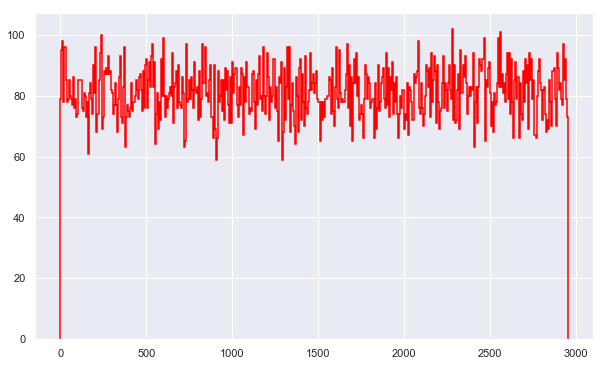

In [36]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Time 

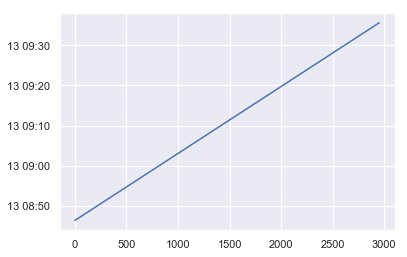

In [37]:
plt.plot(krTimes.timeStamps)

### Event distribution

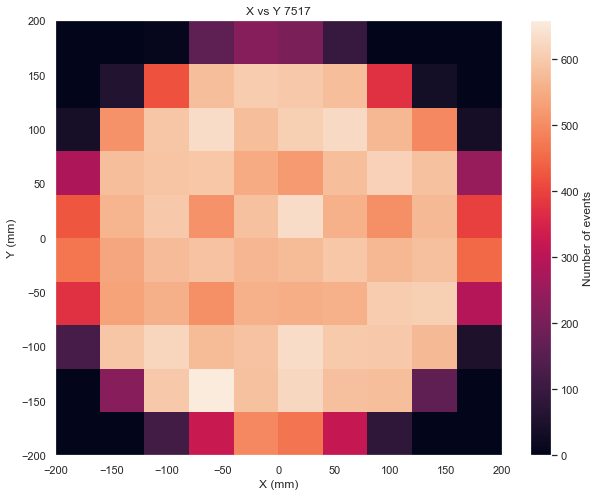

In [38]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y '+str(run_number)),
           profile=False,
           figsize=(10,8))

In [39]:
np.sum(nevt)

40551.0

## Time series

In [40]:
log.setLevel(logging.INFO)

## Divide chamber in sectors of XY

In [41]:
t0 = time.time()
print(len(dst))
print(len(DT))
# KRES = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
KRES = select_xy_sectors_df(dst, krBins.X, krBins.Y) # [edit]
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

40551
40551
 KRES: t = 0.19853901863098145


In [42]:
log.setLevel(logging.INFO)

In [43]:
neM = event_map_df(KRES)

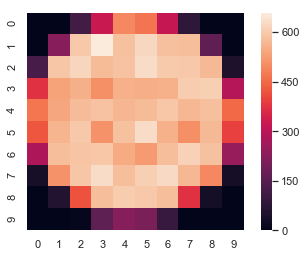

In [44]:
ax = sns.heatmap(neM, square=True)

In [45]:
np.sum(np.sum(neM))

40551

In [46]:
print(neM)

     0    1    2    3    4    5    6    7    8    9
0    0    0  116  325  496  466  320   80    0    0
1    0  226  598  658  586  623  582  580  163    0
2  124  593  620  574  588  630  601  597  573   49
3  373  536  557  506  559  553  560  603  608  293
4  468  540  578  587  566  574  594  569  582  450
5  426  563  597  509  584  632  560  505  572  396
6  282  579  591  595  550  523  579  614  586  247
7   41  509  593  630  579  609  627  569  495   36
8    0   61  419  580  604  598  580  375   34    0
9    0    0   10  160  223  208   96    1    0    0


## Fits in XY sectors

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```


### Single time bin

In [47]:
krNbins.S2e

25

In [48]:
t0 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fpmxy = fit_map_xy_df(selection_map = KRES,
                       event_map     = neM,
                       n_time_bins   = 1,
                       time_diffs    = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy        = 'S2e',
                       fit           = FitType.unbined,
                       n_min         = 2)

t1 = time.time()
print(f' fpmxy: t = {t1 -t0}')

 fpmxy: t = 0.5215270519256592


In [49]:
times = fpmxy[0][0].ts

In [50]:
times

array([1476.75450003])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [51]:
tsm = tsmap_from_fmap(fpmxy)

### Obtain amap from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : DataFrame
    e0    : DataFrame
    lt    : DataFrame
    e0u   : DataFrame
    ltu   : DataFrame
```
 

#### There is a single time series (ts = 0)

In [52]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [53]:
am.lt

,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,35598.484225,9221.567980,12032.316188,10653.922041,13206.554517,9906.883282,NaN,NaN
1,NaN,13327.070996,7688.671925,7846.390070,7746.926519,8599.464980,7796.673215,7847.742978,16828.238296,NaN
2,8402.687294,10142.669670,8379.600371,8400.224062,7787.698028,9315.008191,7365.836060,8014.404883,9498.137163,10046.772550
3,10387.801575,9134.260966,9103.073539,10180.170391,7990.638086,8733.377090,8548.254434,10346.604870,9437.074274,13436.791321
4,13339.519497,7967.161837,7318.045122,7412.559238,8381.132997,8777.570950,7957.132514,7875.839004,7753.532598,13050.667542
5,9274.607266,7539.668804,7859.257271,7896.067767,8098.823876,7401.771083,7586.027442,7561.861199,6999.281733,9035.174215
6,11926.820538,9047.884595,7815.554793,7075.186060,7118.962098,7798.057329,7742.986666,8015.445255,6754.099074,18893.850243
7,18396.518913,9964.772508,7314.344078,6769.673774,7772.113350,7792.137238,7856.373257,7773.411212,13340.959412,25217.699859
8,NaN,-415910.681438,10888.208675,6163.830400,7380.227536,7870.675796,7412.219015,11702.940140,12335.096885,NaN
9,NaN,NaN,-22668.775883,15527.743570,12837.191318,11364.971113,12742.536024,NaN,NaN,NaN


In [54]:
amap_average(am) 

ASectorMap(chi2=1.1289577106869628, e0=10143.286281357558, lt=4539.992673090643, e0u=41.840487557925414, ltu=74514.5853032504, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [55]:
def asm_copy(amap):
    return ASectorMap(chi2  = amap.chi2.copy(),
                      e0    = amap.e0.copy(),
                      lt    = amap.lt.copy(),
                      e0u   = amap.e0u.copy(),
                      ltu   = amap.ltu.copy(),
                      mapinfo   = None)

def regularize_maps_chi2(amap_old, x2range):

    amap = asm_copy(amap_old)
    
    for i in range(len(amap.lt)):
        for j in range(len(amap.lt[i])):
            if amap.chi2[i][j] > x2range[1] or amap.chi2[i][j] < x2range[0]:
                amap.lt[i][j] = np.nan
                amap.ltu[i][j] = np.nan
                amap.e0[i][j] = np.nan
                amap.e0u[i][j] = np.nan

    return amap

In [56]:
if regularize:
    rmap = regularize_maps_chi2(am, x2range = (0, 2))
    amap_average(rmap)
    asm = relative_errors(rmap)
else:
    asm = relative_errors(am)

In [57]:
amv = amap_average(asm)

#### Draw the maps using default colormap

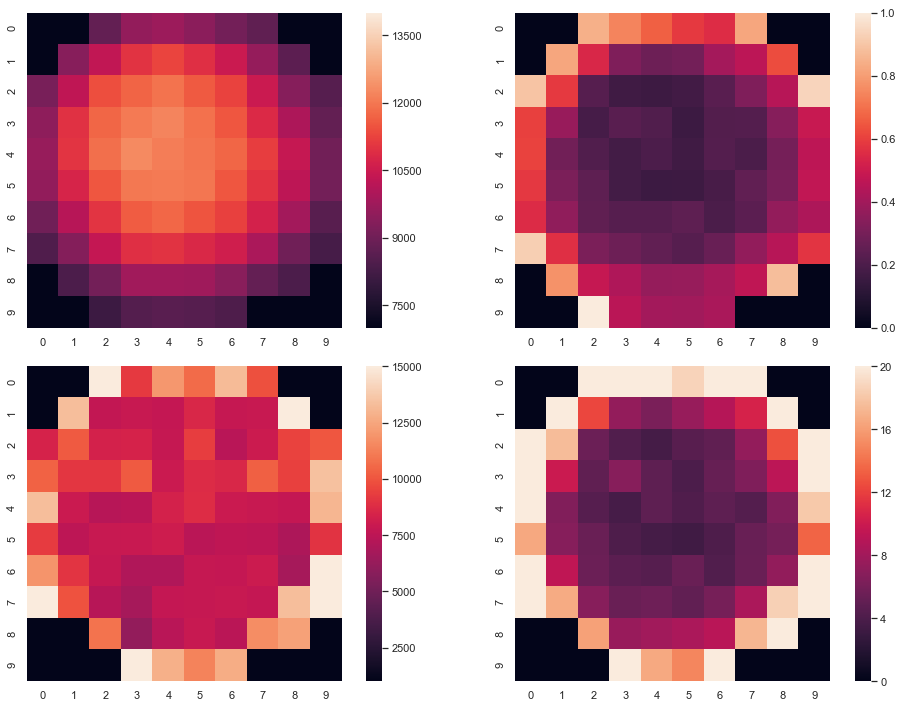

In [58]:
draw_xy_maps(asm,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 20),
            figsize=(14,10))

In [59]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

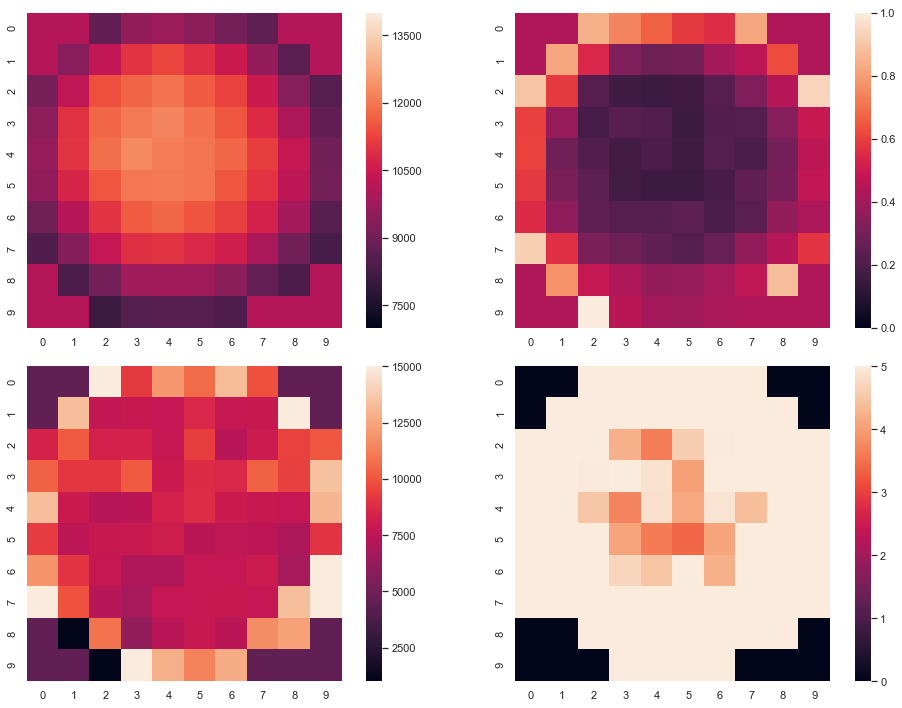

In [60]:
draw_xy_maps(asmAv,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [61]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)

In [62]:
emap_file_name

'kr_emap_xy_10_10_r_7517_ScriptTest.h5'

In [63]:
print('The map info is:')
print(asm.mapinfo)
write_maps(asm, filename=emap_file_name)

The map info is:
xmin          -200
xmax           200
ymin          -200
ymax           200
nx              10
ny              10
run_number    7517
dtype: int64
